_Room Analysis_

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('osfstorage-archive/data/plus/rpi_30_plus.csv', nrows=5)
print(df.columns)

Index(['id', 'date_time', 'rpi_id', 'proximity', 'humidity', 'pressure',
       'light', 'oxidised', 'reduced', 'nh3', 'temperature', 'sound_high',
       'sound_mid', 'sound_low', 'sound_amp'],
      dtype='str')


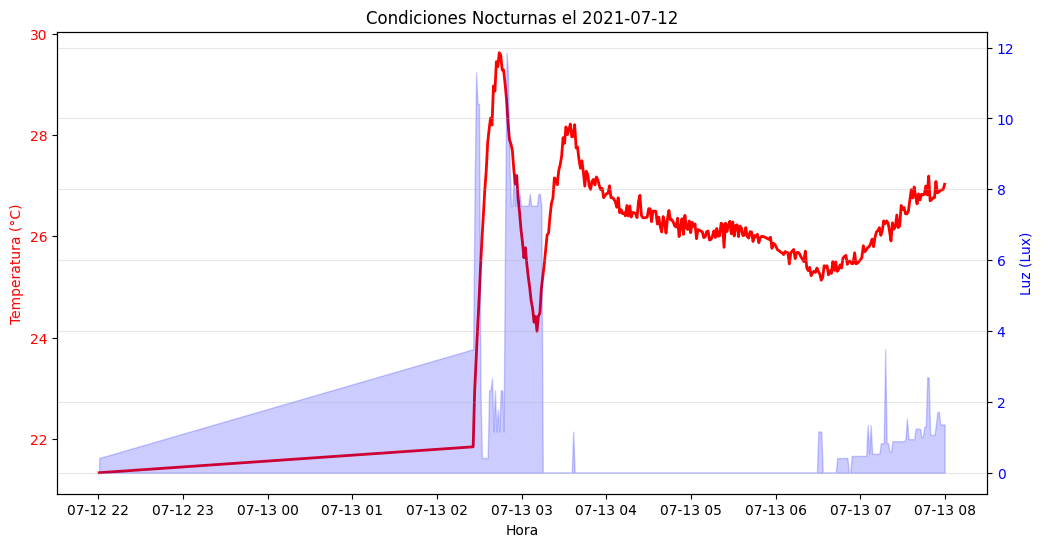

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar (asegurando que no haya espacios en los nombres de columnas)
df = pd.read_csv('osfstorage-archive/data/plus/rpi_30_plus.csv', parse_dates=['date_time'])
df.columns = df.columns.str.strip() 

# 2. Obtener el primer día que aparece en el archivo
primer_dia = df['date_time'].dt.date.min()
proximo_dia = primer_dia + pd.Timedelta(days=1)

# 3. Filtrar primera noche (de 22:00 a 08:00 del día siguiente)
fecha_inicio = f"{primer_dia} 22:00:00"
fecha_fin = f"{proximo_dia} 08:00:00"

noche = df[(df['date_time'] >= fecha_inicio) & (df['date_time'] <= fecha_fin)].copy()

if noche.empty:
    print("No hay datos para ese rango de horas. Prueba con otra fecha.")
else:
    # 4. Graficar
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Hora')
    ax1.set_ylabel('Temperatura (°C)', color='red')
    ax1.plot(noche['date_time'], noche['temperature'], color='red', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='red')

    # Añadir un segundo eje para la Luz
    ax2 = ax1.twinx()
    ax2.set_ylabel('Luz (Lux)', color='blue')
    ax2.fill_between(noche['date_time'], noche['light'], color='blue', alpha=0.2)
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title(f'Condiciones Nocturnas el {primer_dia}')
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
def calculate_sleep_index(row):
    # --- 1. PUNTUACIÓN TEMPERATURA (Máx 10) ---
    temp = row['temperature']
    if 18 <= temp <= 22:
        s_temp = 10
    elif temp < 18:
        s_temp = max(0, 10 - (18 - temp) * 2) # Baja 2 puntos por cada grado de frío
    else:
        s_temp = max(0, 10 - (temp - 22) * 1.5) # Baja 1.5 puntos por cada grado de calor
        
    # --- 2. PUNTUACIÓN LUZ (Máx 10) ---
    # Cualquier valor de luz por encima de 0 empieza a penalizar
    s_light = max(0, 10 - (row['light'] * 2)) 
    
    # --- 3. PUNTUACIÓN SONIDO (Máx 10) ---
    # Usamos sound_amp. Si es mayor a 0.1 (ajustar según tus datos), penaliza
    s_sound = max(0, 10 - (row['sound_amp'] * 50))
    
    # --- 4. PUNTUACIÓN HUMEDAD (Máx 10) ---
    hum = row['humidity']
    if 40 <= hum <= 60:
        s_hum = 10
    else:
        distancia = min(abs(hum - 40), abs(hum - 60))
        s_hum = max(0, 10 - distancia * 0.5)

    # CÁLCULO FINAL PESADO
    index = (s_temp * 0.40) + (s_light * 0.30) + (s_sound * 0.20) + (s_hum * 0.10)
    return index

# Aplicar el cálculo a los datos de la noche
noche['sleep_index'] = noche.apply(calculate_sleep_index, axis=1)

# Calcular la nota media de la noche
nota_final = noche['sleep_index'].mean()

print(f"📊 Índice de Confort de Sueño para esta noche: {nota_final:.2f} / 10")

📊 Índice de Confort de Sueño para esta noche: 4.89 / 10


📋 Resumen 2021-08-28 00:00-08:00:
       temperature    light   humidity   sound_db  sleep_index
mean    29.384724  0.10840  27.895091  25.624922     3.736345
min     24.957603  0.00000  25.895726  19.753139     3.294786
max     31.033036  2.50815  33.233334  29.445133     5.800469
📊 Índice de Confort de Sueño 2021-08-28 00:00-08:00 -> media: 3.74
🔊 Picos de sonido detectados (en dB relativos): 0 | Primeros 5 (si hay): []
✅ Muestras: 470 | Primer registro: 2021-08-28 00:01:00 | Último registro: 2021-08-28 07:59:08


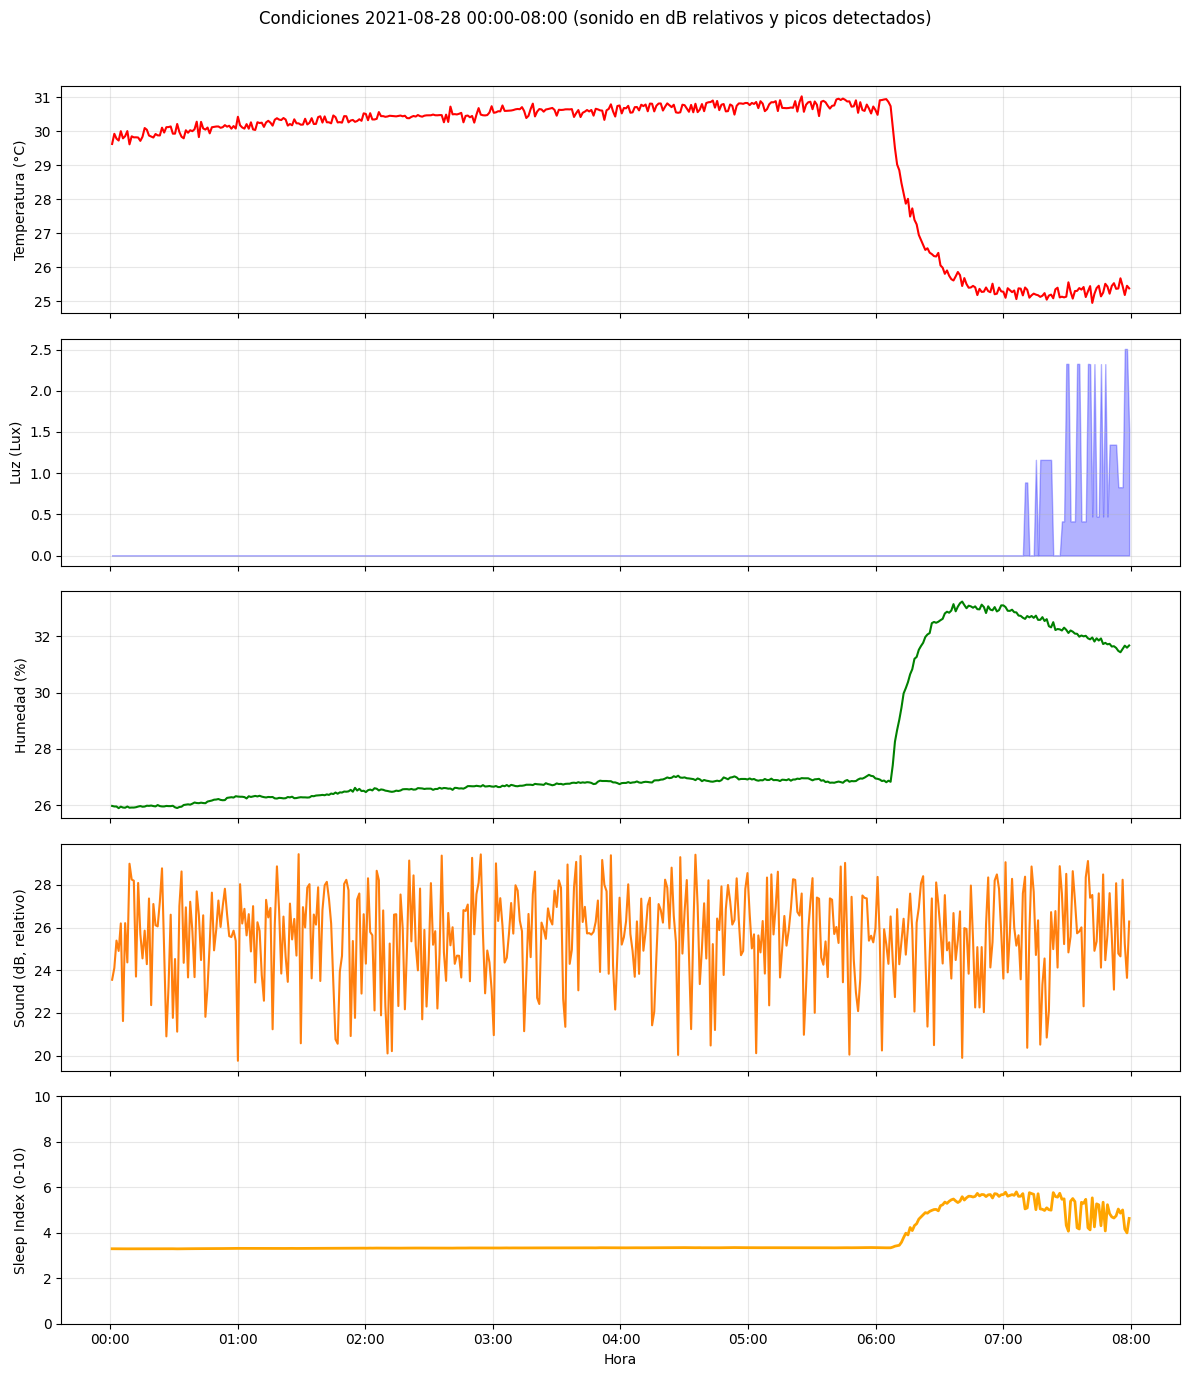

In [6]:
# Análisis de 00:00 a 08:00 para una fecha específica (editable)
import matplotlib.dates as mdates

# --- Cambia esta fecha si quieres analizar otra ---
date_str = "2021-08-28"
try:
    target_date = pd.to_datetime(date_str).date()
except Exception as e:
    raise ValueError(f"Fecha inválida: {date_str}") from e

fecha_inicio = pd.to_datetime(f"{target_date} 00:00:00")
fecha_fin = pd.to_datetime(f"{target_date} 08:00:00")

madrugada = df[(df['date_time'] >= fecha_inicio) & (df['date_time'] <= fecha_fin)].copy()

if madrugada.empty:
    # Mostrar rango de datos disponibles para ayudar al diagnóstico
    min_dt = df['date_time'].min()
    max_dt = df['date_time'].max()
    print(f"⚠️ No hay datos entre 00:00 y 08:00 para {date_str}.")
    print(f"   Rango disponible en el dataset: {min_dt} — {max_dt}")
else:
    # Calcular sleep_index para el intervalo si no existe
    if 'sleep_index' not in madrugada.columns:
        madrugada['sleep_index'] = madrugada.apply(calculate_sleep_index, axis=1)

    # Calcular dB relativos y detectar picos en dB
    eps = 1e-9
    madrugada['sound_db'] = 20 * np.log10(madrugada['sound_amp'].astype(float) + eps)

    s_db_mean = madrugada['sound_db'].mean()
    s_db_std = madrugada['sound_db'].std(ddof=0)
    madrugada['sound_db_z'] = (madrugada['sound_db'] - s_db_mean) / (s_db_std if s_db_std>0 else 1)
    spikes_z = madrugada['sound_db_z'] > 3  # umbral z-score en dB

    try:
        from scipy.signal import find_peaks
        height = s_db_mean + 3 * (s_db_std if s_db_std>0 else 0)
        peaks_idx, _ = find_peaks(madrugada['sound_db'].values, height=height)
        peak_times = madrugada['date_time'].iloc[peaks_idx]
    except Exception:
        peaks_idx = np.where(spikes_z)[0]
        peak_times = madrugada['date_time'].iloc[peaks_idx]

    n_spikes = len(peaks_idx)

    # Resumen rápido (mostrar dB en vez de amplitude)
    resumen = madrugada[['temperature','light','humidity','sound_db','sleep_index']].agg(['mean','min','max'])
    print(f"📋 Resumen {date_str} 00:00-08:00:\n", resumen)
    print(f"📊 Índice de Confort de Sueño {date_str} 00:00-08:00 -> media: {madrugada['sleep_index'].mean():.2f}")
    print(f"🔊 Picos de sonido detectados (en dB relativos): {n_spikes} | Primeros 5 (si hay):", list(peak_times[:5].astype(str)))
    print(f"✅ Muestras: {len(madrugada)} | Primer registro: {madrugada['date_time'].min()} | Último registro: {madrugada['date_time'].max()}")

    # Gráficas: 5 filas (Temperatura, Luz, Humedad, Sound dB, Sleep Index)
    fig, axes = plt.subplots(5, 1, figsize=(12, 14), sharex=True)

    # Temperatura
    axes[0].plot(madrugada['date_time'], madrugada['temperature'], color='red')
    axes[0].set_ylabel('Temperatura (°C)')
    axes[0].grid(alpha=0.3)

    # Luz
    axes[1].fill_between(madrugada['date_time'], madrugada['light'], color='blue', alpha=0.3)
    axes[1].set_ylabel('Luz (Lux)')
    axes[1].grid(alpha=0.3)

    # Humedad
    axes[2].plot(madrugada['date_time'], madrugada['humidity'], color='green')
    axes[2].set_ylabel('Humedad (%)')
    axes[2].grid(alpha=0.3)

    # Sonido: sólo dB relativos y picos
    axes[3].plot(madrugada['date_time'], madrugada['sound_db'], color='tab:orange', label='sound_db (dB relativo)')
    if len(peaks_idx) > 0:
        axes[3].scatter(madrugada['date_time'].iloc[peaks_idx], madrugada['sound_db'].iloc[peaks_idx], color='red', marker='x', label='picos')
    axes[3].set_ylabel('Sound (dB, relativo)')
    axes[3].grid(alpha=0.3)

    # Sleep Index
    axes[4].plot(madrugada['date_time'], madrugada['sleep_index'], color='orange', linewidth=2)
    axes[4].set_ylabel('Sleep Index (0-10)')
    axes[4].set_ylim(0, 10)
    axes[4].grid(alpha=0.3)

    # Formato eje X
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Hora')
    plt.suptitle(f'Condiciones {date_str} 00:00-08:00 (sonido en dB relativos y picos detectados)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

🔎 Rango de noches evaluadas: 2021-07-12 — 2022-07-01  (total días: 355)
Noches con datos: 314
    night_day  sci_mean  samples   night_dt
0  2021-07-12  4.892359      327 2021-07-12
3  2021-07-15  2.891126      589 2021-07-15
4  2021-07-16  2.899690      588 2021-07-16
5  2021-07-17  2.936483      589 2021-07-17
6  2021-07-18  3.027318      589 2021-07-18


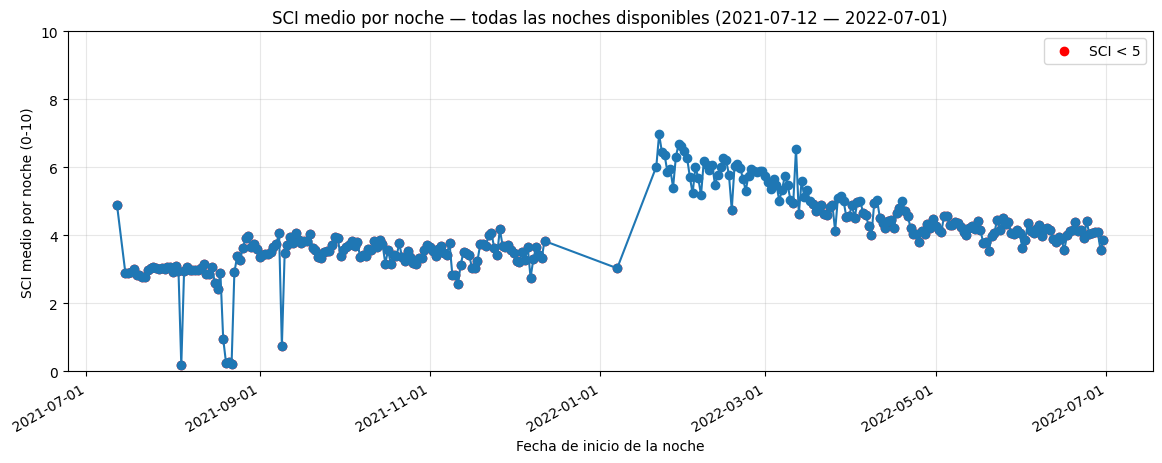

In [7]:
min_date = df['date_time'].dt.date.min()
max_date = df['date_time'].dt.date.max()
all_nights = pd.date_range(min_date, max_date, freq='D').date

results_all = []
for night_day in all_nights:
    night_start = pd.to_datetime(f"{night_day} 22:00:00")
    night_end = night_start + pd.Timedelta(hours=10)  # hasta 08:00 del día siguiente

    night_df = df[(df['date_time'] >= night_start) & (df['date_time'] <= night_end)].copy()

    if night_df.empty:
        results_all.append({'night_day': night_day, 'sci_mean': np.nan, 'samples': 0})
        continue

    night_df['sleep_index'] = night_df.apply(calculate_sleep_index, axis=1)
    sci_mean = night_df['sleep_index'].mean()
    results_all.append({'night_day': night_day, 'sci_mean': sci_mean, 'samples': len(night_df)})

results_df = pd.DataFrame(results_all)
plot_df = results_df.dropna(subset=['sci_mean']).copy()
plot_df['night_dt'] = pd.to_datetime(plot_df['night_day'])

print(f"🔎 Rango de noches evaluadas: {min_date} — {max_date}  (total días: {len(all_nights)})")
print(f"Noches con datos: {len(plot_df)}")
print(plot_df.head())

# Gráfica
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(plot_df['night_dt'], plot_df['sci_mean'], marker='o', linestyle='-')
ax.set_ylabel('SCI medio por noche (0-10)')
ax.set_ylim(0, 10)
ax.set_xlabel('Fecha de inicio de la noche')
ax.set_title(f'SCI medio por noche — todas las noches disponibles ({min_date} — {max_date})')
ax.grid(alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Resaltar noches con SCI < 5
low = plot_df[plot_df['sci_mean'] < 5]
if not low.empty:
    ax.scatter(pd.to_datetime(low['night_day']), low['sci_mean'], color='red', label='SCI < 5')
    ax.legend()

plt.show()

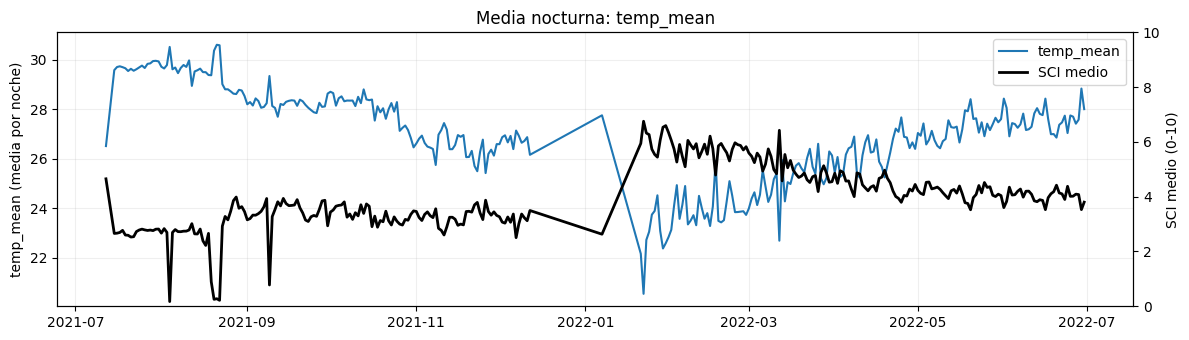

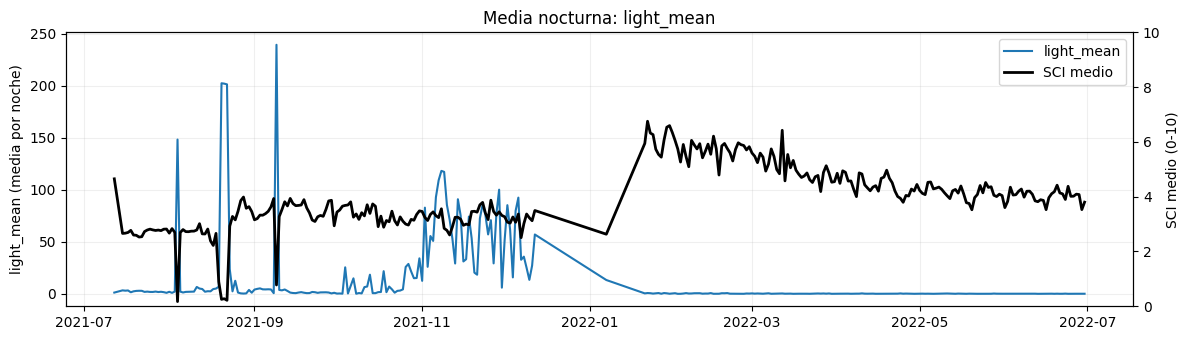

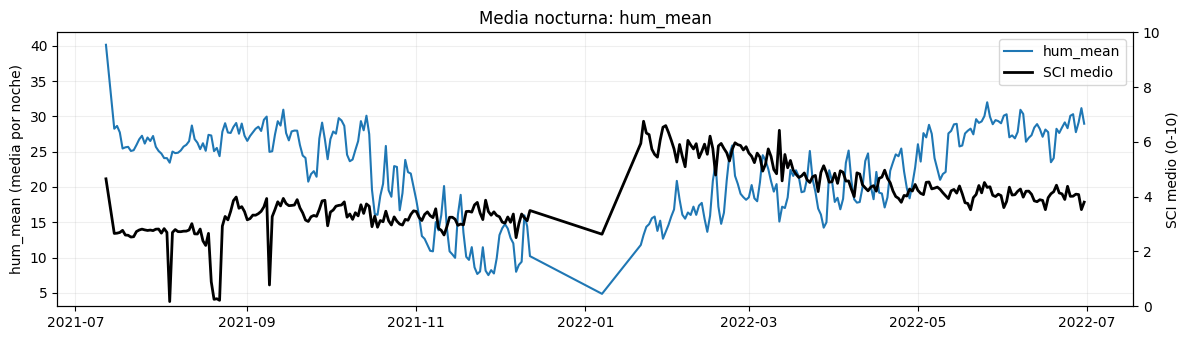

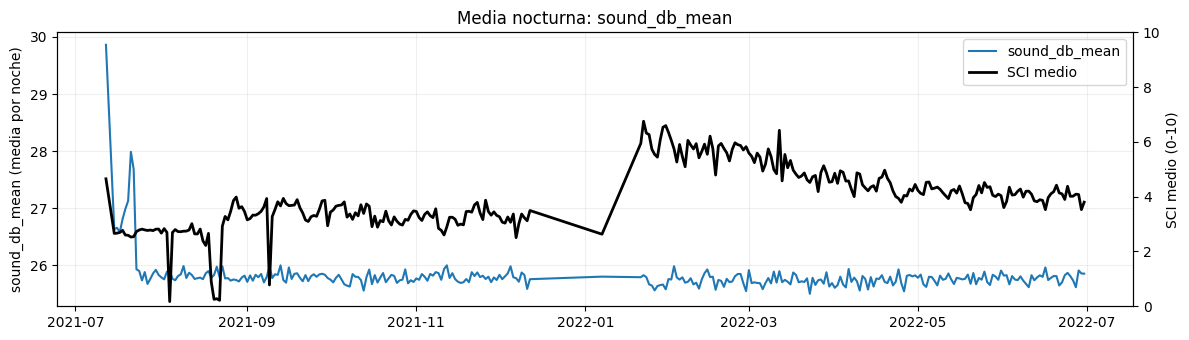

In [8]:
# 4) Gráficas de contribuciones por noche (medias y porcentajes)
# Calcula la media nocturna de cada factor y muestra:
#  - series temporales de cada factor + SCI
#  - área apilada de contribuciones normalizadas (porcentaje)

# Reconstruir night_summary si no existe
try:
    night_summary
except NameError:
    # Reusar df_h si existe, sino construirlo
    try:
        df_h
    except NameError:
        df_h = df.copy()
        df_h['hour'] = df_h['date_time'].dt.hour
        mask_morning = df_h['hour'] <= 8
        df_h.loc[mask_morning, 'night_date'] = (df_h.loc[mask_morning, 'date_time'] - pd.Timedelta(days=1)).dt.date
        mask_night = df_h['hour'] >= 22
        df_h.loc[mask_night, 'night_date'] = df_h.loc[mask_night, 'date_time'].dt.date
        df_h = df_h[(df_h['hour'] >= 22) | (df_h['hour'] <= 8)].copy()
    # asegurar sleep_index y sound_db
    if 'sleep_index' not in df_h.columns:
        df_h['sleep_index'] = df_h.apply(calculate_sleep_index, axis=1)
    eps = 1e-9
    df_h['sound_db'] = 20 * np.log10(df_h['sound_amp'].astype(float) + eps)

    night_summary = df_h.groupby('night_date').agg(
        sci_mean=('sleep_index','mean'),
        temp_mean=('temperature','mean'),
        light_mean=('light','mean'),
        hum_mean=('humidity','mean'),
        sound_db_mean=('sound_db','mean'),
        samples=('sleep_index','count')
    ).dropna()

# Alinear con las noches calculadas en results_df (si existe)
if 'results_df' in globals():
    nights_with_sci = pd.to_datetime(results_df.dropna(subset=['sci_mean'])['night_day']).dt.date
    night_summary = night_summary.loc[night_summary.index.isin(nights_with_sci)]

if night_summary.empty:
    print('⚠️ No hay noches con SCI disponible para graficar contribuciones.')
else:
    features = ['temp_mean','light_mean','hum_mean','sound_db_mean']
    df_plot = night_summary[features + ['sci_mean']].copy()
    df_plot.index = pd.to_datetime(df_plot.index)
    df_plot = df_plot.sort_index()

    # 1) Series temporales separadas: una figura por factor (+ SCI en eje secundario)
    for f in features:
        plt.figure(figsize=(12,3.5))
        plt.plot(df_plot.index, df_plot[f], label=f, color='C0')
        plt.ylabel(f"{f} (media por noche)")
        plt.title(f"Media nocturna: {f}")
        plt.grid(alpha=0.2)

        # SCI en eje secundario
        ax = plt.gca()
        ax2 = ax.twinx()
        ax2.plot(df_plot.index, df_plot['sci_mean'], color='k', linewidth=2, label='SCI medio')
        ax2.set_ylabel('SCI medio (0-10)')
        ax2.set_ylim(0,10)

        # Leyendas
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right')
        plt.tight_layout()
        plt.show()


Modelo: Regresión Lineal
Coef: 0.0054, Intercept: 3.1250
RMSE: 0.909, MAE: 0.655


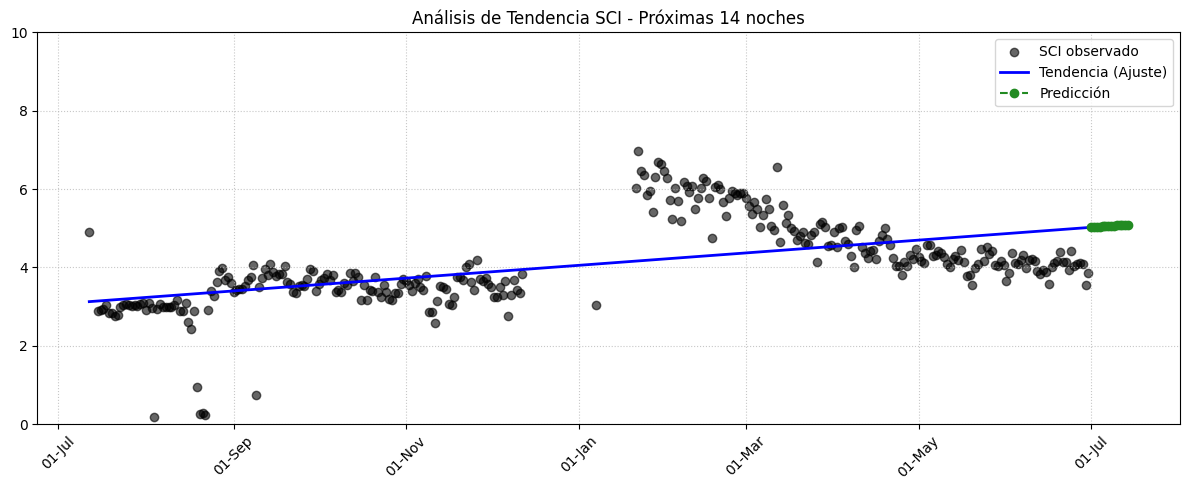

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Preparación de datos
if 'plot_df' not in globals():
    plot_df = results_df.dropna(subset=['sci_mean']).copy()

plot_df = plot_df.sort_values('night_dt').copy()

if len(plot_df) < 3:
    print("⚠️ No hay suficientes noches con datos.")
else:
    # 2. Variable temporal
    plot_df['t'] = (plot_df['night_dt'] - plot_df['night_dt'].min()).dt.days
    
    # Sklearn necesita X como matriz 2D (n_samples, n_features)
    X = plot_df[['t']].values 
    y = plot_df['sci_mean'].values

    # 3. Ajuste del Modelo
    model = LinearRegression()
    model.fit(X, y)
    
    # Predicción sobre el entrenamiento
    pred_train = model.predict(X)
    
    # Métricas (Compatibilidad total)
    mse = mean_squared_error(y, pred_train)
    rmse = np.sqrt(mse) # Más seguro que squared=False
    mae = mean_absolute_error(y, pred_train)
    
    coef = model.coef_[0]
    intercept = model.intercept_

    print(f"Modelo: Regresión Lineal")
    print(f"Coef: {coef:.4f}, Intercept: {intercept:.4f}")
    print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")

    # 4. Predicción futura
    n_forecast = 14
    last_date = plot_df['night_dt'].max()
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=n_forecast, freq='D')
    
    # Calculamos 't' para el futuro
    future_t = (future_dates - plot_df['night_dt'].min()).days.values.reshape(-1, 1)
    future_pred = model.predict(future_t)
    future_pred = np.clip(future_pred, 0, 10)

    # 5. Gráfica
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.scatter(plot_df['night_dt'], y, color='black', label='SCI observado', alpha=0.6)
    ax.plot(plot_df['night_dt'], pred_train, color='blue', linewidth=2, label='Tendencia (Ajuste)')
    ax.plot(future_dates, future_pred, linestyle='--', marker='o', color='forestgreen', label='Predicción')
    
    ax.set_ylim(0, 10)
    ax.set_title(f'Análisis de Tendencia SCI - Próximas {n_forecast} noches')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=45)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()